# read datas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

import json
import numpy as np
import pandas as pd

with open('./data/typeid.json') as f:
    typeid = json.load(f)
with open('./data/bw_result.json') as f:
    typebw = json.load(f)
rentdf = pd.read_csv('./data/clear_rent_items.csv')
envdf = pd.read_csv('./data/clear_env_items.csv')

In [2]:
for key, value in typeid.items():
    print(key, value, typebw[key])

101 Food 300
102 Supermarket 2100
201 Bus 900
202 MRT 4300
203 UBike 3500
204 Train 6600
205 Exam 1700
206 Charger 5400
207 Towing 6000
301 BookStore 2400
302 DepartmentStore 1200
303 Library 4800
304 Museum 4100
305 Theater 2200
401 Park 1600
402 Scenic 1300
403 Sport 1400
501 School 4000
502 Hospital 5800
503 Pharmacy 3500
504 Police 6600
505 FireStation 6600


# import

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
#latlng => TWD97
from LatLonToTWD97 import LatLonToTWD97
c = LatLonToTWD97()

# computing


In [4]:
%%time
#用KDE計算各類別分數
rentdata = list(map(c.convert,rentdf.loc[:,['lat','lng']].values))
col = '{}:{}'
kdtree = {}
kdedf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    data = list(map(c.convert,envdf[envdf.typeID==int(key)].loc[:,['lat','lng']].values))
    kdtree[key] = KDTree(data)
    kde = KernelDensity(bandwidth=bw)
    kde.fit(data)
    kdedf[name] = kde.score_samples(rentdata)

CPU times: user 1min 3s, sys: 44.9 ms, total: 1min 3s
Wall time: 1min 3s


In [5]:
%%time
#使用bandwidth當作半徑計算個數
col = '{}:{}'
countdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    countdf[name] = kdtree[key].query_radius(rentdata,r=bw, count_only=True)

CPU times: user 1.11 s, sys: 1.99 ms, total: 1.11 s
Wall time: 1.11 s


In [43]:
#compute avg cost of food
foodf = envdf[envdf.typeID==101]

def foodavg(array):
    if len(array)>0:
        return np.nanmean(foodf.loc[array,'cost'].dropna())
    else:
        return 0

%%time
favg = list(map(foodavg,kdtree['101'].query_radius(rentdata,r=typebw['101'])))

In [51]:
pd.Series(favg).describe()

count    20748.000000
mean       201.817761
std        107.014719
min          0.000000
25%        134.948276
50%        184.030952
75%        253.056303
max       1200.000000
dtype: float64

In [52]:
favg = pd.Series(favg).fillna(value=184)

In [48]:
kdedf.head()

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,-20.690013,-21.150177,-21.197688,-22.016565,-22.078798,-24.070453,-20.763704,-21.756216,-21.739868,-21.057701,...,-21.344104,-35.143631,-19.832454,-19.526913,-20.361726,-21.793622,-21.625844,-23.361540,-21.923599,-21.836211
1,-29.418300,-21.889287,-22.285826,-22.832456,-22.543544,-25.073176,-22.244460,-22.183499,-21.850956,-21.961800,...,-21.739857,-41.770144,-20.666102,-21.221613,-21.728591,-22.215835,-22.034202,-24.561982,-22.322319,-22.267184
2,-20.076350,-21.296837,-21.731911,-21.742753,-21.986086,-23.743658,-20.897927,-21.616462,-21.792917,-21.111542,...,-21.251749,-32.216696,-20.373445,-20.070019,-20.628840,-21.686197,-21.466098,-22.801697,-21.770699,-21.691362
3,-18.322282,-21.146282,-21.160755,-21.730500,-21.913950,-23.602874,-20.689591,-21.574648,-21.643634,-20.955411,...,-21.215287,-32.858452,-19.895306,-19.265852,-20.328033,-21.655434,-21.489876,-22.908381,-21.757554,-21.643540
4,-21.883530,-24.074363,-30.514663,-24.571018,-22.389492,-21.066033,-22.398776,-22.229883,-21.559772,-22.419500,...,-22.287442,-33.924655,-22.219667,-23.843253,-21.268603,-22.364983,-22.166921,-25.454403,-22.287819,-22.227708


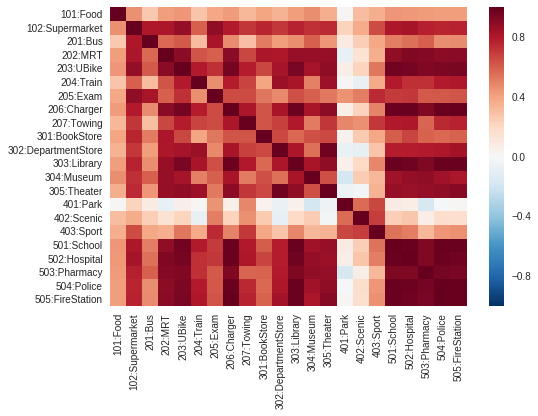

In [58]:
corr = kdedf.corr()
sns.heatmap(corr)

In [13]:
countdf.head()

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,4,8,63,2,11,0,10,5,1,4,...,3,0,20,31,20,56,6,2,10,6
1,0,2,10,1,9,0,0,5,1,0,...,3,0,5,1,1,44,4,0,8,4
2,12,6,25,2,11,0,11,6,1,4,...,3,0,10,4,11,59,7,2,12,8
3,159,6,72,3,13,0,12,6,1,4,...,4,0,13,35,18,62,7,2,11,8
4,8,0,0,0,8,1,1,2,0,0,...,1,0,1,0,7,29,3,0,7,3


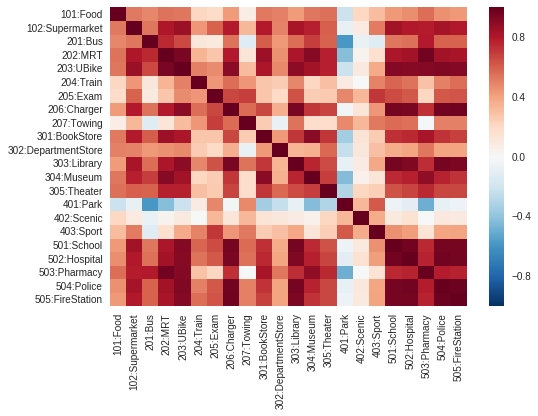

In [14]:
corr = countdf.corr()
sns.heatmap(corr)

In [15]:
import re
lar = re.compile(r'^\d')
typecountdf = pd.DataFrame()
for key in countdf.columns:
    name = lar.findall(key)[0]
    if name in typecountdf.columns:
        typecountdf[name] = typecountdf[name] + countdf[key]
    else:
        typecountdf[name] = countdf[key]

In [16]:
typecountdf.head()

,1,2,3,4,5
0,12,92,9,71,80
1,2,26,5,7,60
2,18,56,10,25,88
3,165,107,11,66,90
4,8,12,3,8,42


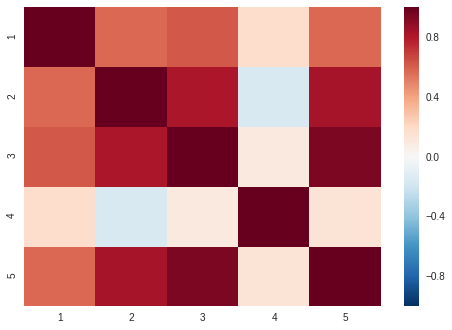

In [17]:
corr = typecountdf.corr()
sns.heatmap(corr)

In [18]:
expdf = kdedf.applymap(lambda x:np.exp(x))

In [19]:
expdf.head(3)

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,1.033811e-09,6.525216e-10,6.222444e-10,2.743641e-10,2.578102e-10,3.518319e-11,9.603686e-10,3.559553e-10,3.618224e-10,7.157424e-10,...,5.374936e-10,5.461537e-16,2.437108e-09,3.308031e-09,1.435538e-09,3.428863e-10,4.055227e-10,7.148453e-11,3.010938e-10,3.285898e-10
1,1.674150e-13,3.116042e-10,2.095988e-10,1.213362e-10,1.619806e-10,1.290798e-11,2.184508e-10,2.321821e-10,3.237802e-10,2.898086e-10,...,3.618262e-10,7.235309e-19,1.058829e-09,6.075340e-10,3.659256e-10,2.247944e-10,2.695675e-10,2.152121e-11,2.020878e-10,2.135427e-10
2,1.909643e-09,5.635096e-10,3.647129e-10,3.607798e-10,2.828551e-10,4.878208e-11,8.397414e-10,4.093453e-10,3.431280e-10,6.782253e-10,...,5.894984e-10,1.019687e-14,1.418813e-09,1.921770e-09,1.099028e-09,3.817722e-10,4.757647e-10,1.251263e-10,3.508372e-10,3.798055e-10


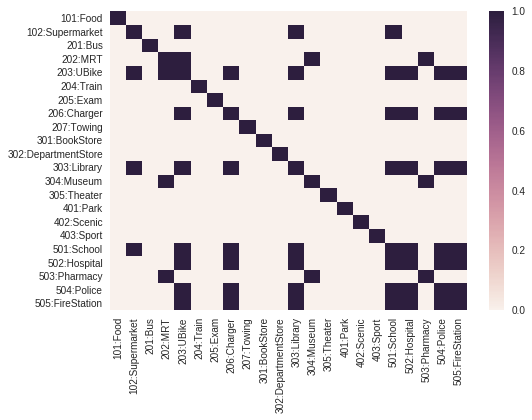

In [59]:
corr = expdf.corr()
sns.heatmap(corr>0.95)

In [53]:
#df = rentdf[['pet', 'rent']].join(kdedf)
df = rentdf[['pet', 'rent']].join(expdf)
#df = rentdf[['pet', 'rent']].join(countdf)
#df = rentdf[['pet', 'rent']].join(typecountdf)

In [54]:
df['foodcost'] = favg

In [23]:
yn = {'N':0,'Y':1}
df['pet'] = df.pet.map(lambda x: yn.get(x))

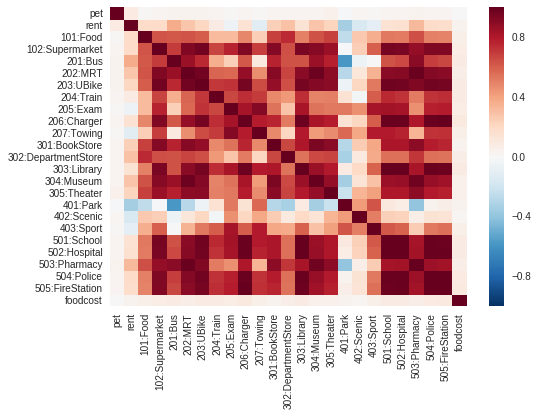

In [24]:
corr = df.corr()
sns.heatmap(corr)

In [25]:
#Normalizer vs. StandarScaler
from sklearn.preprocessing import Normalizer

nml = Normalizer(norm='max')
X = nml.fit_transform(df)

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(df)

In [27]:
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
X = mmsc.fit_transform(df)

In [28]:
# 直接使用scikit-learn實作
from sklearn.cluster import KMeans
# n_init=10, 隨機做十次  自動找出SSE最小的那一次
# max_iter=300, 或是 tol=1e-04, 為中止條件
clus = 4

km = KMeans(n_clusters=clus, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)


In [29]:
y_km = km.fit_predict(X)

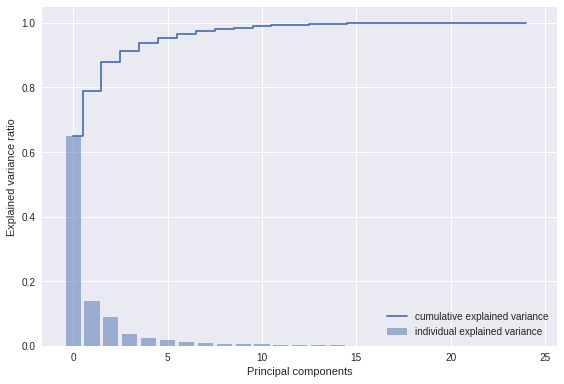

In [30]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

#print('\nEigenvalues \n%s' % eigen_vals)

tot = sum(eigen_vals)
# 將特徵值排序  並計算百分比
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 加總
cum_var_exp = np.cumsum(var_exp)


length = len(X.T)
plt.bar(range(0, length), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, length), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [31]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low

eigen_pairs.sort(reverse=True)

# 取前兩名重要的向量  並排列整齊
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

X_pca = X.dot(w)

In [32]:
# 作圖
def clusterplot(plot_X,labels):
    plotting_X = pd.DataFrame(plot_X,columns=['x','y'])
    n_cluster = len(np.unique(labels))
    colors = ['r', 'b', 'g', 'c', 'm', 'y']
    for l, c in zip(range(n_cluster), colors):
        plt.scatter(plotting_X[labels == l].x , 
                    plotting_X[labels == l].y, 
                    c=c, label=l, s=10)
    plt.legend()
    plt.grid()
    plt.tight_layout()

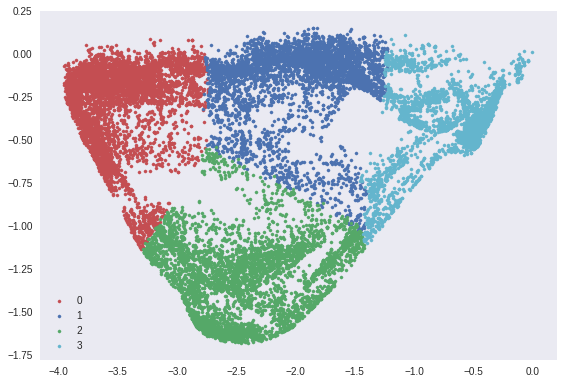

In [33]:
clusterplot(X_pca,y_km)

In [34]:
resultdf = rentdf.join(df ,how='left', lsuffix='_left', rsuffix='_right')

In [35]:
resultdf['y'] = y_km

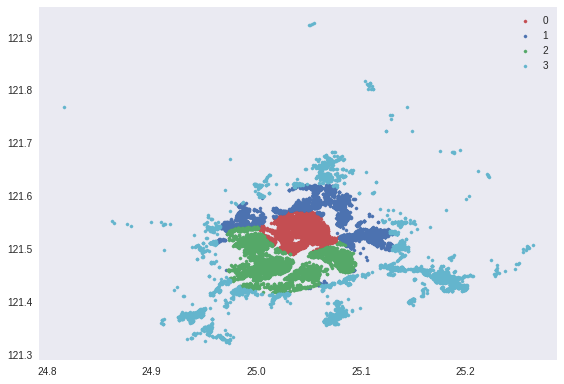

In [36]:
# 作圖

colors = ['r', 'b', 'g', 'c', 'm', 'y']

for l, c in zip(range(clus), colors):
    plt.scatter(resultdf[y_km == l].lat , 
                resultdf[y_km == l].lng, 
                c=c, label=l, s=10)


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [37]:
resultdf.groupby('y').count().ID

y
0    6876
1    4665
2    5114
3    4093
Name: ID, dtype: int64

In [38]:
resultdf.groupby('y').mean().sort_values('rent_left',ascending=False).T

y,0,1,3,2
ID,1.272764e+04,1.330877e+04,1.377146e+04,1.372100e+04
cityID,1.090156e+02,1.207841e+02,2.303604e+02,2.315684e+02
rent_left,3.378746e+04,3.368213e+04,1.596292e+04,1.563418e+04
space,2.343590e+01,2.811232e+01,2.345598e+01,1.758619e+01
lat,2.504354e+01,2.506527e+01,2.509560e+01,2.502534e+01
lng,1.215345e+02,1.215540e+02,1.214673e+02,1.214762e+02
floor,5.578534e+00,4.993783e+00,5.784022e+00,4.922957e+00
unit,1.589194e+03,1.326063e+03,8.295697e+02,1.081573e+03
pet_right,2.136417e-01,1.770632e-01,1.759101e-01,1.885022e-01
rent_right,3.378746e+04,3.368213e+04,1.596292e+04,1.563418e+04


In [39]:
pd.DataFrame(w, index=df.columns).apply(np.abs).sort_values([0,1], ascending=False)

,0,1
503:Pharmacy,0.280694,0.234317
202:MRT,0.277962,0.139608
203:UBike,0.273446,0.004569
304:Museum,0.263190,0.171125
305:Theater,0.252238,0.113469
102:Supermarket,0.251459,0.034304
501:School,0.250140,0.108405
303:Library,0.249052,0.102971
301:BookStore,0.245912,0.127275
502:Hospital,0.240425,0.089093


In [40]:
resultdf.groupby(['y','label']).count().ID

y  label
0  住        1346
   套        5421
   雅         105
1  住         843
   套        3737
   雅          82
2  住         483
   套        4556
   雅          74
3  住         668
   套        3385
   雅          39
Name: ID, dtype: int64

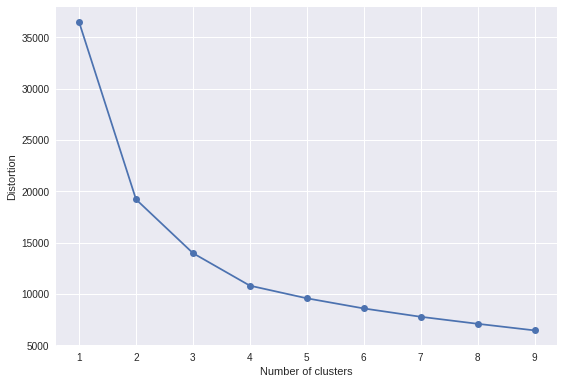

In [41]:
# 如果選取k越大 SSE必然越小
# 但分太多類別也沒有意義
# 這邊藉由SSE 的變化來選擇要分幾類
distortions = []
sup = 10
for i in range(1, sup):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, sup), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [55]:
df.head()

,pet,rent,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,...,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation,foodcost
0,N,25000,1.033811e-09,6.525216e-10,6.222444e-10,2.743641e-10,2.578102e-10,3.518319e-11,9.603686e-10,3.559553e-10,...,5.461537e-16,2.437108e-09,3.308031e-09,1.435538e-09,3.428863e-10,4.055227e-10,7.148453e-11,3.010938e-10,3.285898e-10,124.500000
1,N,32000,1.674150e-13,3.116042e-10,2.095988e-10,1.213362e-10,1.619806e-10,1.290798e-11,2.184508e-10,2.321821e-10,...,7.235309e-19,1.058829e-09,6.075340e-10,3.659256e-10,2.247944e-10,2.695675e-10,2.152121e-11,2.020878e-10,2.135427e-10,0.000000
2,N,25000,1.909643e-09,5.635096e-10,3.647129e-10,3.607798e-10,2.828551e-10,4.878208e-11,8.397414e-10,4.093453e-10,...,1.019687e-14,1.418813e-09,1.921770e-09,1.099028e-09,3.817722e-10,4.757647e-10,1.251263e-10,3.508372e-10,3.798055e-10,233.166667
3,N,5000,1.103403e-08,6.550678e-10,6.456553e-10,3.652277e-10,3.040131e-10,5.615678e-11,1.034249e-09,4.268246e-10,...,5.367299e-15,2.288644e-09,4.294840e-09,1.484730e-09,3.936990e-10,4.645851e-10,1.124648e-10,3.554794e-10,3.984098e-10,130.213836
4,N,6000,3.134035e-10,3.504588e-11,5.593072e-14,2.132761e-11,1.889589e-10,7.098038e-10,1.872127e-10,2.216585e-10,...,1.848032e-15,2.239345e-10,4.415774e-11,5.796464e-10,1.936472e-10,2.360633e-10,8.816437e-12,2.091815e-10,2.221412e-10,99.625000
